In [7]:
import open_clip
import torch
import time
import sys
import matplotlib.pyplot as plt
from torchprofile import profile_macs
from datasets import load_dataset
from torchvision.transforms import v2 as T

sys.path.append('..')
sys.path.append('../..')
from encoders.openclip_encoder import PatchDropout, PatchDropoutFov

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model, prep, _ = open_clip.create_model_and_transforms("ViT-B-16", "laion2b_s34b_b88k", force_patch_dropout=.75)
model = model.visual

Text(0.5, 0, 'Mask ratio')

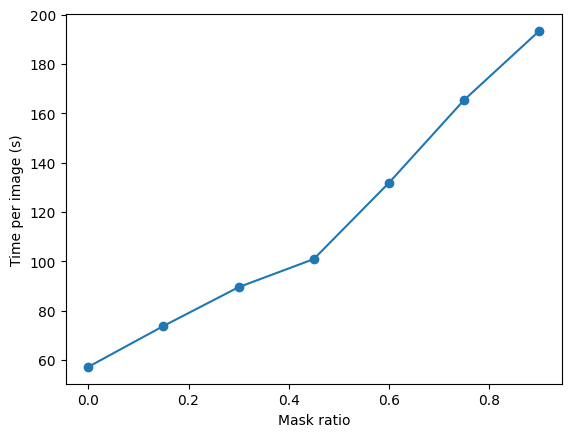

In [3]:
device = 'cuda:0'

def time_inference(model, mask_ratio, n_iter=100):
    model = model.to(device)
    model.eval()
    model.patch_dropout = PatchDropout(mask_ratio)
    inp = torch.zeros(6, 3, 224, 224).to(device)
    with torch.no_grad():
      times = []
      for _ in range(n_iter):
        inp = inp.normal_()
        start = time.time()
        _ = model(inp)
        times.append(time.time() - start)
    return sum(times) / len(times), torch.tensor(times).std().item() / (len(times) ** .5)

# grid sweep over mask ratios
mask_ratios = [0, .15, .3, .45, .6, .75, .9]
means, stds = [], []
for mask_ratio in mask_ratios:
    mean, std = time_inference(model, mask_ratio)
    means.append(mean)
    stds.append(std)

plt.errorbar(mask_ratios, [1/m  for m in means], yerr=[s*10 for s in stds], fmt='o-')
plt.ylabel('Time per image (s)')
plt.xlabel('Mask ratio')

In [61]:
# 4363729968
((16852059696 / 1e9) - (4363729968 / 1e9))/(16852059696 / 1e9)

0.7410565802211243

In [ ]:
model.patch_dropout = PatchDropout(0.5)
profile_macs(model, torch.randn(1, 3, 224, 224).to('cuda:0'))

In [ ]:
flops = []

for mask_ratio in mask_ratios:
    model.patch_dropout = PatchDropout(mask_ratio)
    flops_, _ = flopth(model, in_size=((3, 224, 224),), show_detail=False, bare_number=True)
    flops.append(flops_)
    
plt.plot(mask_ratios, [f / 1e9 for f in flops], 'o-')

In [ ]:
def patchify(imgs, patch_size):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x, patch_size):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs
  
ds = load_dataset("HuggingFaceM4/COCO")
ds.set_format(type="torch")

In [66]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_patches(tensor):
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(14, 14), axes_pad=0.03)
    tensor = tensor.reshape(14*14, 16, 16, 3)

    for i, ax in enumerate(grid):
        patch = tensor[i].numpy() 
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

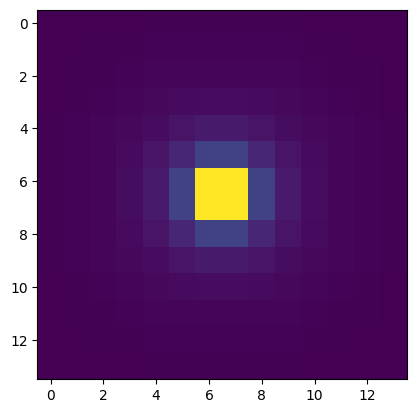

In [146]:
std_dev = .1
num_tokens = 196
token_locs = torch.arange(num_tokens)
distances = ((token_locs // num_tokens**.5) - 6.5)**2 \
                        + ((token_locs % num_tokens**.5) - 6.5)**2

# Calculate probabilities based on normal distribution
# probabilities = torch.exp(-distances / (2 * std_dev**2))
probabilities = 1/(std_dev*(1+distances/std_dev**2))
plt.imshow(probabilities.reshape(14, 14).numpy())

In [113]:
fov = PatchDropoutFov(.75, False)

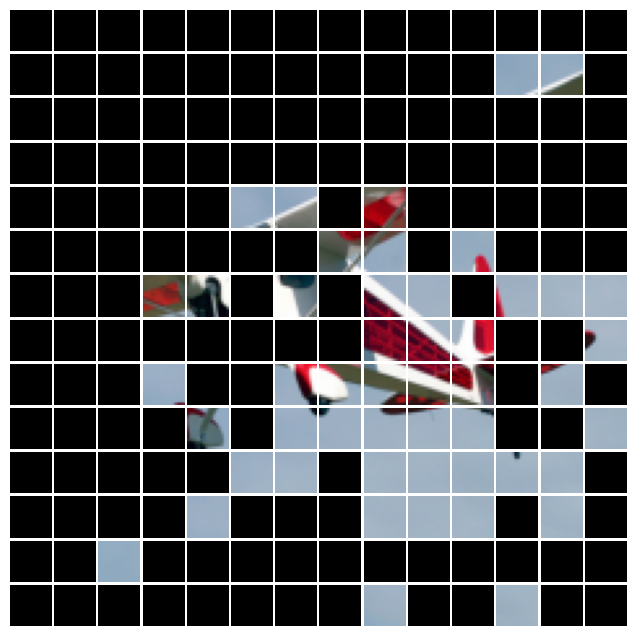

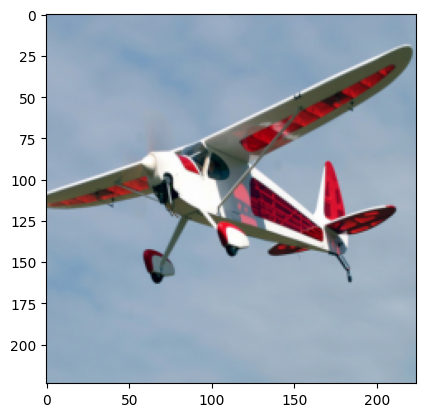

In [152]:
fov = PatchDropoutFov(.75, False)
resize = T.Resize((224, 224))
img = resize(ds['validation'][100]['image'][None])
patches = patchify(img, 16)
patches, keep = fov(patches, torch.tensor([8.5, 8.5]), .1, True)
blank = patchify(torch.zeros_like(img), 16)
blank[:, keep] = patches
plot_patches(blank)
plt.imshow(img[0].permute(1, 2, 0))